<a href="https://colab.research.google.com/github/krzysztofrentflejsz/kaggle-house-price-prediction/blob/main/Real_estate_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

General note for anyone reading this file: I write comments of the code **above** a code cell.

Steps to conduct

1. EDA
* Check column types and empty values
* Check correlations
* Check y

2. Pipelines
* Set them up

3. Preprocessing
* Data imputing (different approaches)
* Data encoding (one hot vs. ordinal)
* Scaling

4. Feature engineering
* Interactive features

5. Model selection


In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.feature_selection import SelectFwe, SelectPercentile
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.linear_model import Ridge, ElasticNet,  Lasso, LinearRegression
from sklearn.linear_model import LassoLarsCV, RidgeCV, ElasticNetCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from dask.bag.core import random_state_data_python
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVR

from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p
from scipy.stats import f_oneway, ttest_ind
from numpy import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.read_csv('/content/drive/My Drive/Data projects/Real estate price prediction project/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Data projects/Real estate price prediction project/test.csv')

## EDA

Based on the initial analysis we can make the following 2 crucial observations:

1. Dataset contains columns with different data types, which means we will have to handle them
* Continuous (e.g. LotFrontage, GrLivArea)
* Descrete (e.g. OverallQual, YrSold)
* Categorical (e.g. LotShape, SaleCondition)

2. Dataset contains missing values, hence data imputation will have to be carried out.

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
X = train_df.drop('SalePrice', axis=1)
y = train_df[['SalePrice']].copy()

Visaulising discrete, numerical and categorical values against the target variable.

* Descrete variables are detected as numerical values (i.e. not objects) that have at most 30 unique values (30 is an arbitrarily chosen number)



In [13]:
# Threshold for discrete variables
unique_threshold = 30

# Exclude the 'Id' column from the DataFrame
X_filtered = X.drop(columns=['Id'])

# Select numerical columns
numerical_features = X_filtered.select_dtypes(include=np.number).columns

# Identify discrete numerical features
discrete_variables = [feature for feature in numerical_features if X_filtered[feature].nunique() <= unique_threshold]

# Identify continuous numerical features by excluding discrete ones
continuous_variables = [feature for feature in numerical_features if feature not in discrete_variables]

# Identify categorical features
categorical_variables = X_filtered.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Discrete variables: ({len(discrete_variables)}) {discrete_variables}\n")
print(f"Continuous variables: ({len(continuous_variables)}) {continuous_variables}\n")
print(f"Categorical variables: ({len(categorical_variables)}) {categorical_variables}")

Discrete variables: (18) ['MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Continuous variables: (18) ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']

Categorical variables: (43) ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 

In [8]:
import matplotlib.pyplot as plt
import math

def plot_variables_grid(df, variables, target_var=None, charts_per_row=5, plot_type='hist', bins=30):
    """
    Plots multiple variables in a grid layout.

    Parameters:
    - df: pandas DataFrame containing the data.
    - variables: list of column names to plot.
    - target_var: the target variable name as a string (required for 'bar' plot_type).
    - charts_per_row: number of charts to display per row in the grid.
    - plot_type: type of plot ('hist' for histograms, 'bar' for bar plots).
    - bins: number of bins for histograms.
    """
    if plot_type not in ['hist', 'bar']:
        raise ValueError("Unsupported plot_type. Use 'hist' or 'bar'.")

    if plot_type == 'bar' and target_var is None:
        raise ValueError("target_var must be specified for 'bar' plot_type.")

    total_charts = len(variables)
    rows = math.ceil(total_charts / charts_per_row)

    fig, axes = plt.subplots(rows, charts_per_row, figsize=(20, 4 * rows))
    fig.tight_layout(pad=5.0)
    axes = axes.flatten()

    for idx, feature in enumerate(variables):
        ax = axes[idx]
        if plot_type == 'hist':
            ax.hist(df[feature].dropna(), bins=bins, edgecolor='black')
            ax.set_xlabel(feature)
            ax.set_ylabel('Frequency')
            ax.set_title(f'Histogram of {feature}')
        elif plot_type == 'bar':
            df.groupby(feature)[target_var].mean().plot.bar(ax=ax)
            ax.set_xlabel(feature)
            ax.set_ylabel(target_var)
            ax.set_title(f'{feature} vs {target_var}')

    # Remove any unused subplots
    for idx in range(total_charts, len(axes)):
        fig.delaxes(axes[idx])

    plt.show()

Noteworthy observations based on the discrete variable graphs:

1. OverallCond (overall condition) has an oddly looking relation with the price. We would intuitively expect the graph to look similar to the OverallQual one.
* Next step: This should be investigated to understand the relationship.
2. Higher number of bathrooms and half-bathrooms don't always translate to a higher price.
* Next step: Check what is the relationship of the summed values.
3. BedroomAbvGr has an odd relation with the price. We would expect a strong positive correlation between the variables, but the graph depicts a relation which is not so clear.
* Next step: This should be investigated to understand the relationship.
4. Some of the variables (e.g. TotRmsabvGrd, GarageCars) exhibit a positive correlation up to the second largest value and then they have a unexpected negative turn for the extreme value.
* Next step: This should be investigated to understand the relationship.


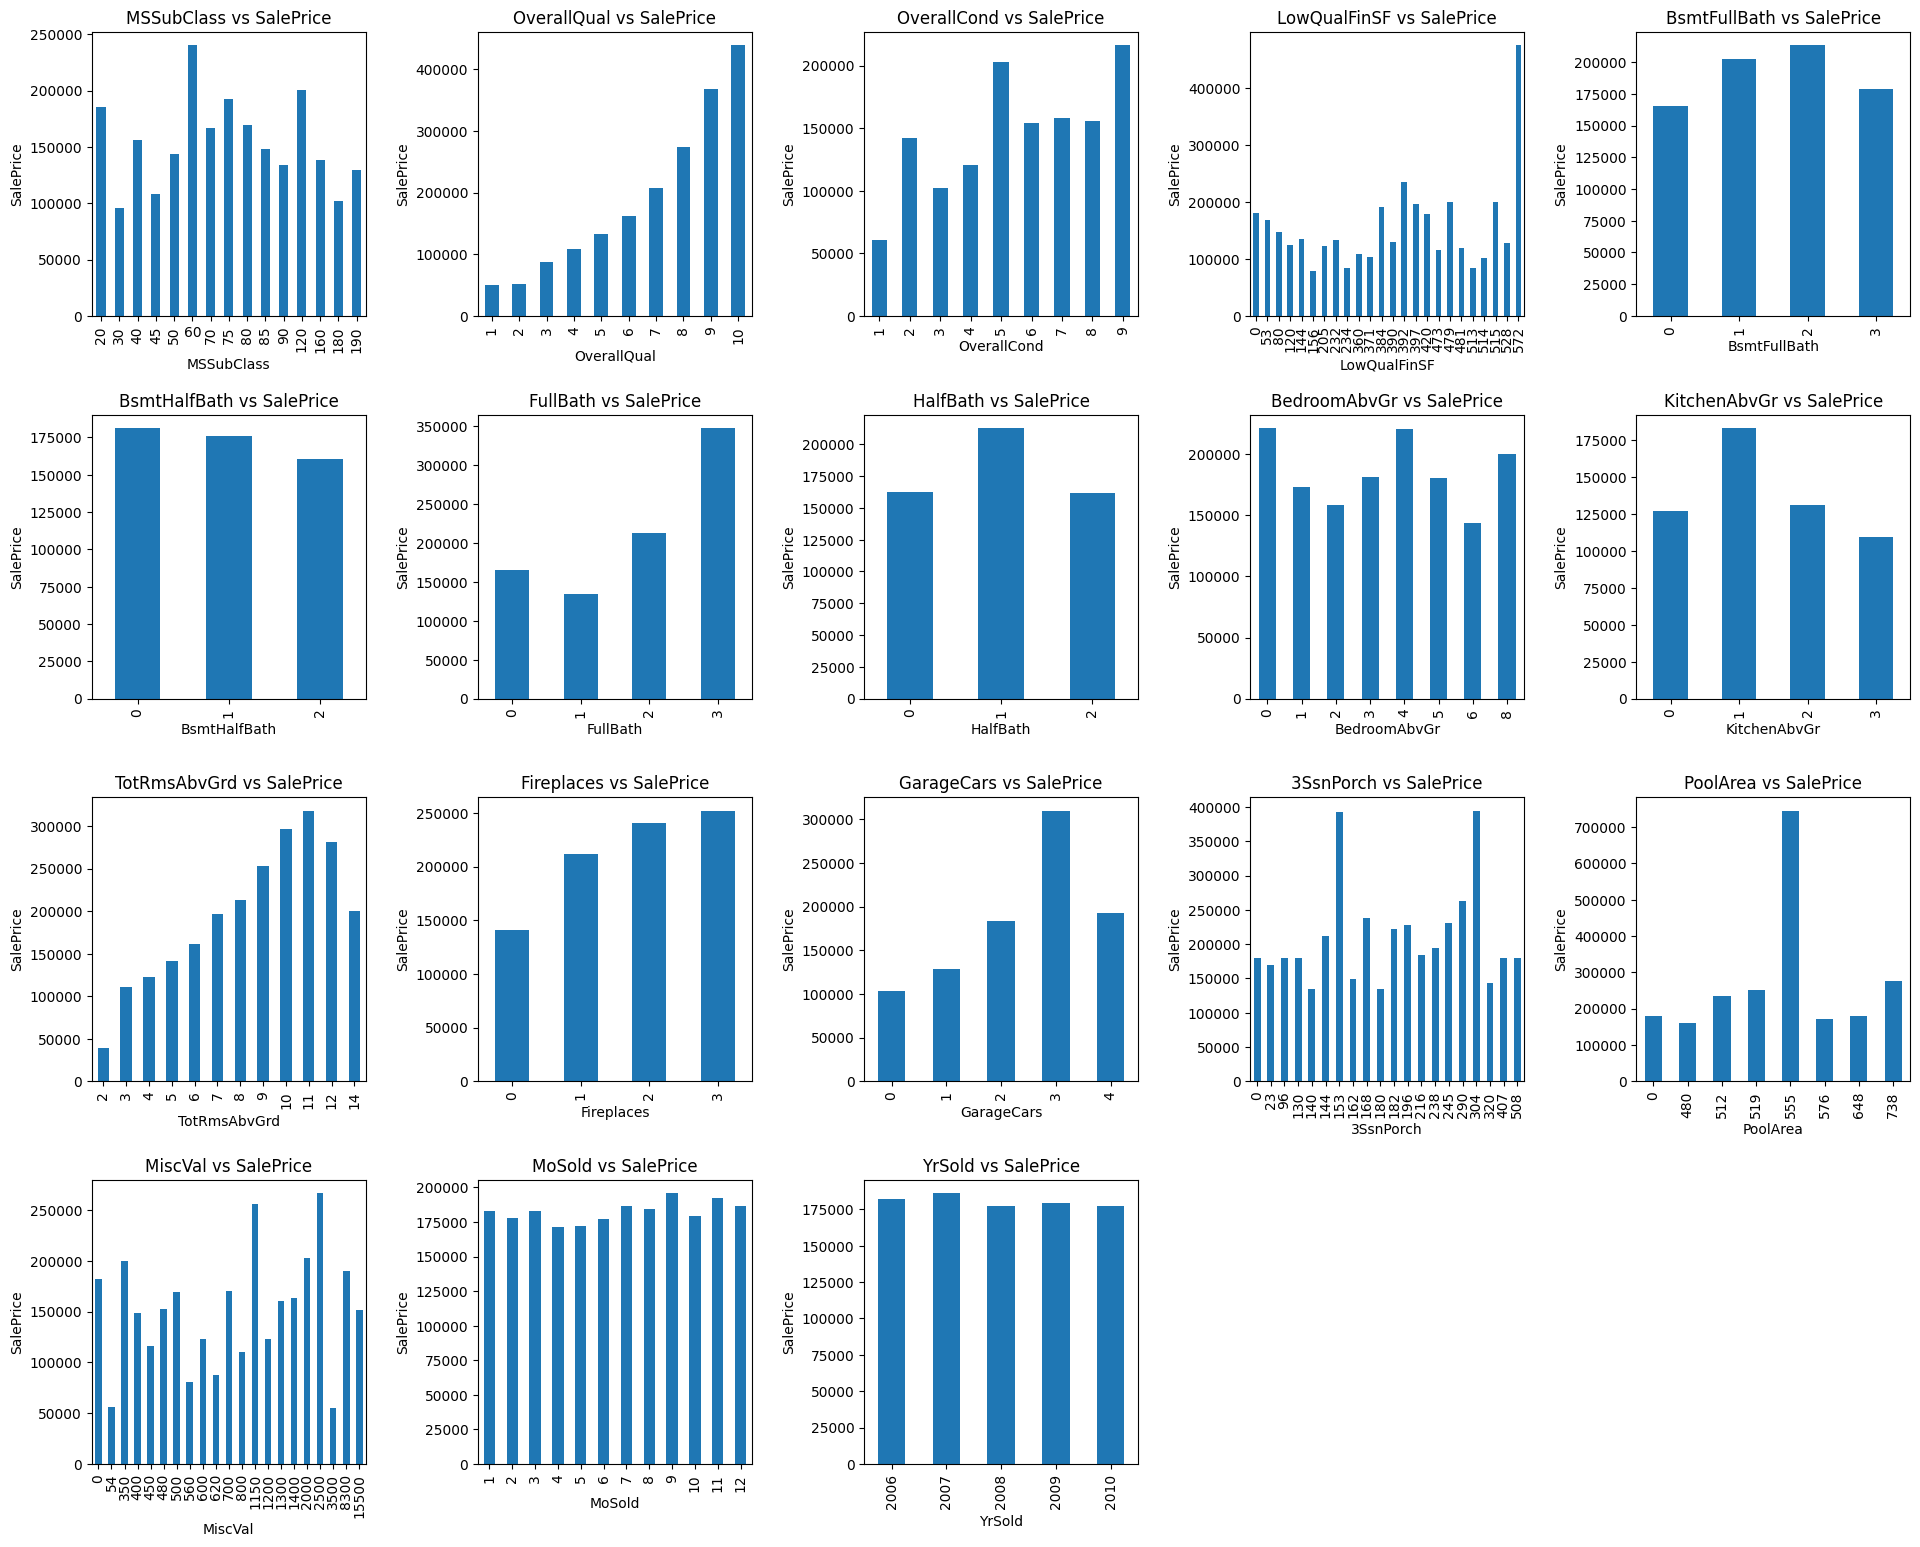

In [9]:
plot_variables_grid(train_df, discrete_variables, 'SalePrice', charts_per_row=5, plot_type='bar')

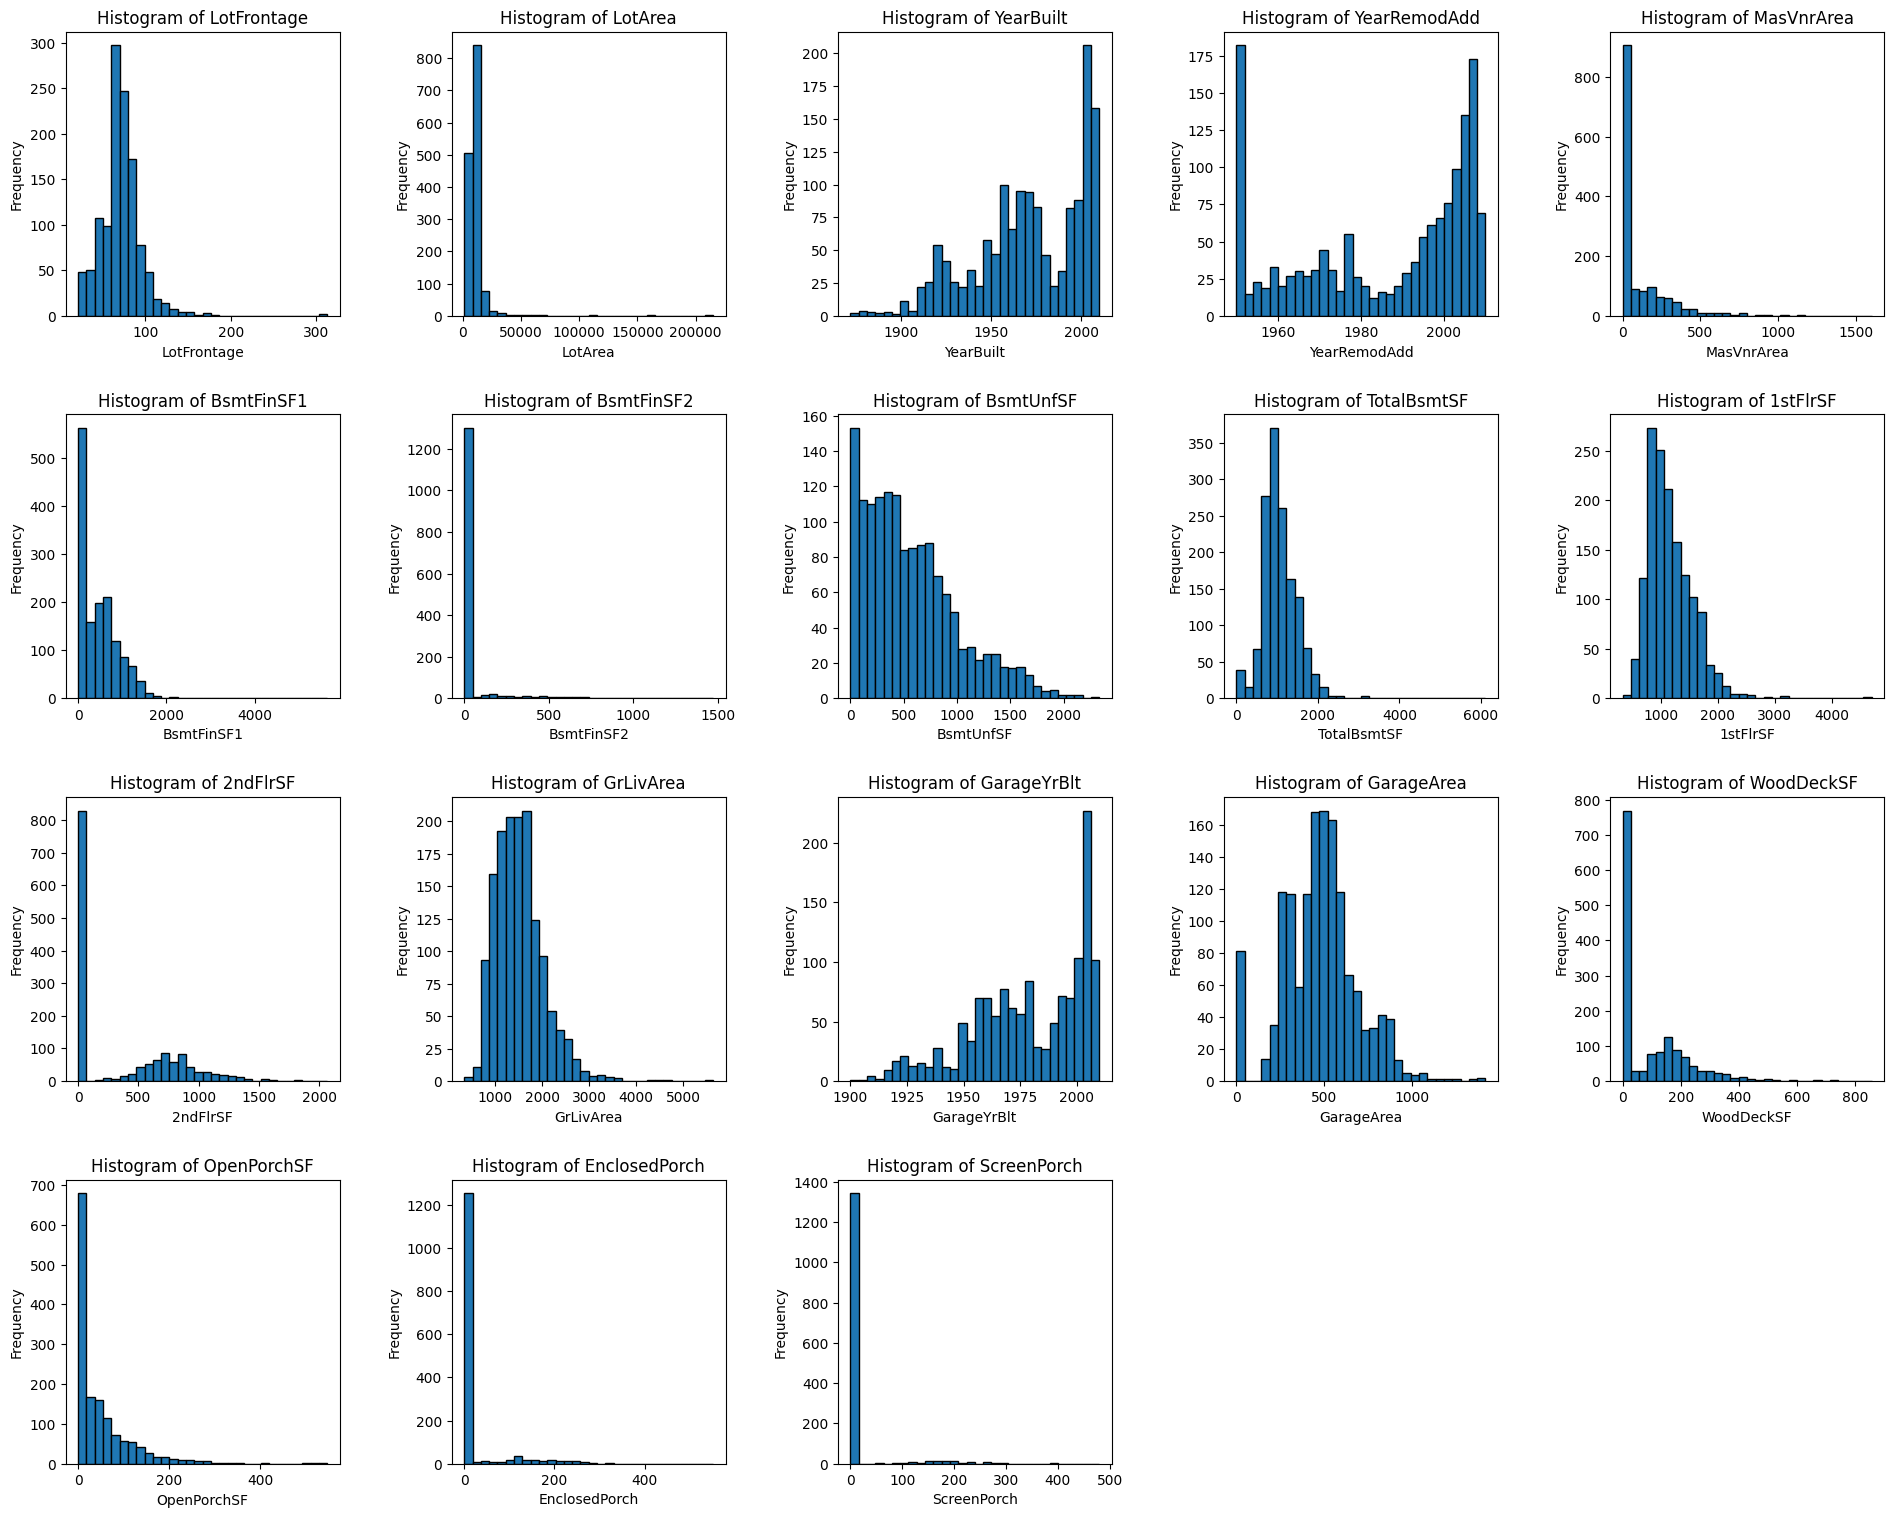

In [10]:
plot_variables_grid(train_df, continuous_variables, 'SalePrice', charts_per_row=5, plot_type='hist')

Noteworthy observations based on the continuous variable graphs:

1. Many of the graphs exhibit skewed distributions (e.g. GrLivArea).
* Next steps: Consider adjustment (e.g. log transformation).
2. Some of the variables seem to have very low variation (e.g. BsmtFinSF2)
* Next steps: Check if the values can be combined with others to derive more meaningful model drivers. Consider creating categorical binary variable out of some of them as it might be more meaningful that a house has a certain feature (e.g. porch) more than its squar footage. Lastly, consider dropping the least important features when fittting the model to reduce overfitting (can also be done as part of regularization).
3. Variable YearRemodAdd has the highest number of occourances in the lowest year, which seems odd.
* Next steps: Investigate the reason for the spike and adjust the variable if needed.

Noteworthy observations based on the categorical variable graphs:

1. Some features have clear ordinal character (e.g. KitchenQual)
* Next steps: Consider ordinal encoding instead of one-hot encoding for these variables
2. Average sale prices vary a lot by neighbourhoods.
* Next step: Consider grouping neighbourhoods into bins or introducing interaction values between neighbourhood variable and other variables.
3. Irregular lot shapes correspond to higher average sale prices, which is surprising, but likely dependent on the definition of irregular.
* Next step: Apply one-hot encoding
4. There are many variables for which at the first glance it is hard to assess whether they are meaningful or are simply noise, which should be ignored.
* Next step: Look into regularization and feature selection.

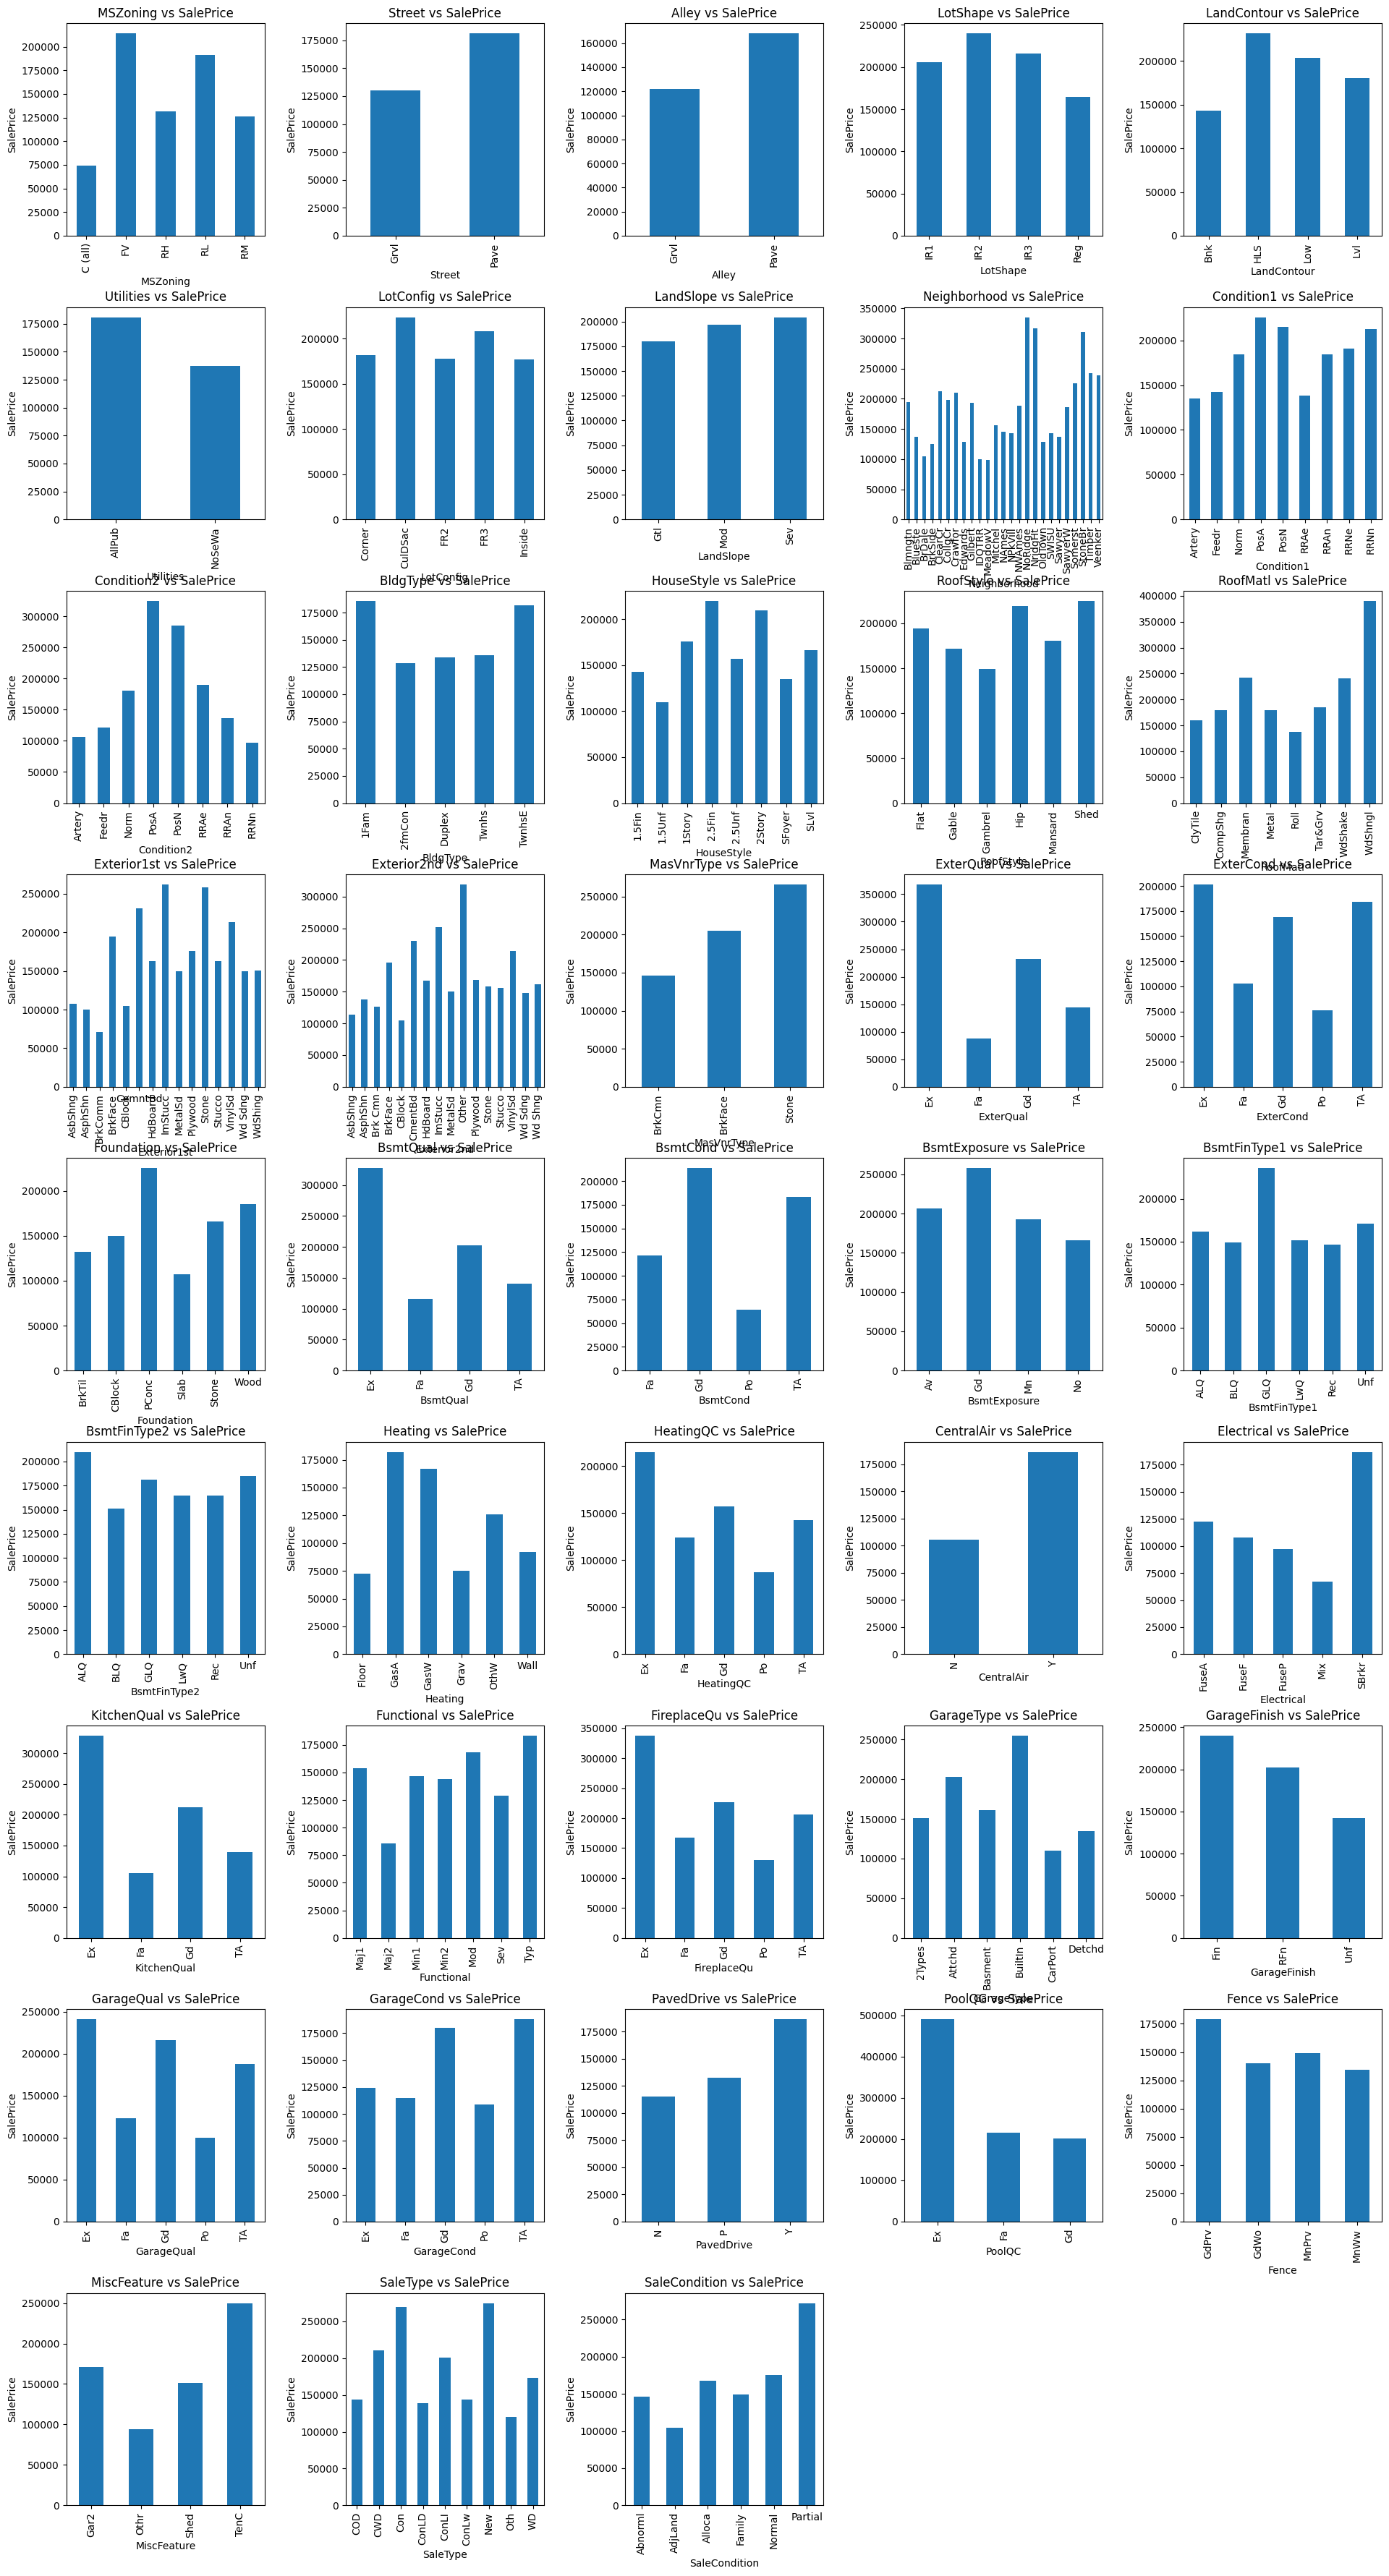

In [14]:
plot_variables_grid(train_df, categorical_variables, 'SalePrice', charts_per_row=5, plot_type='bar')

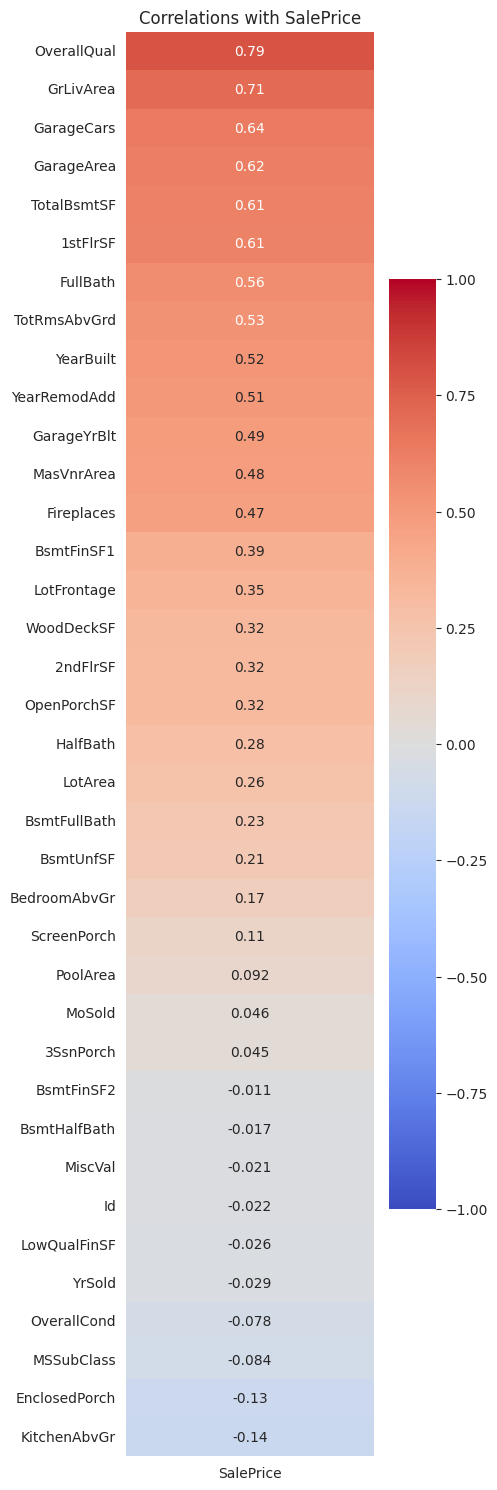

In [ ]:
# Select only numerical columns
numerical_df = train_df.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = numerical_df.corr()

# Extract correlations with 'SalePrice' and sort them
corr_with_saleprice = corr_matrix['SalePrice'].drop('SalePrice').sort_values(ascending=False)

# Set up the matplotlib figure
plt.figure(figsize=(4, len(corr_with_saleprice) * 0.5))  # Adjust height based on number of features

# Draw the heatmap
sns.heatmap(corr_with_saleprice.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Add title
plt.title('Correlations with SalePrice')

# Display the plot
plt.show()

In [ ]:
X = train_df.drop('SalePrice', axis=1)
y = train_df[['SalePrice']].copy()

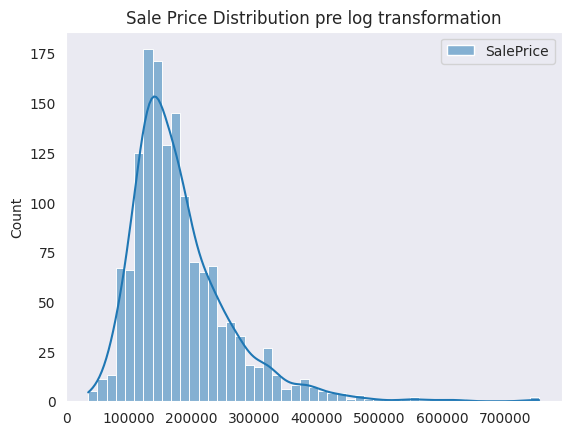

In [ ]:
# Check the distribution of the sale price - variable which we will predict
sns.histplot(y, kde=True)
plt.title('Sale Price Distribution pre log transformation')
plt.show()

In [ ]:
# Log-transform skewed numerical features
y = np.log1p(y)

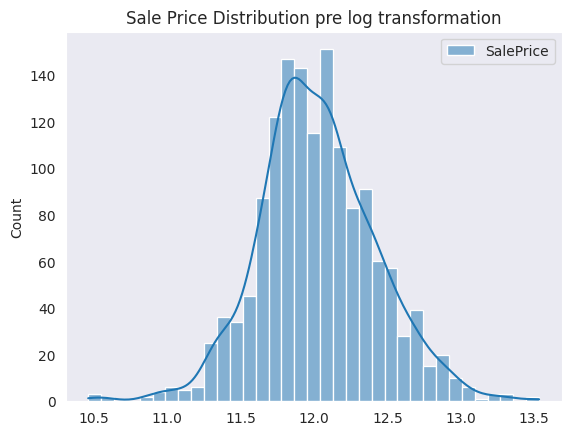

In [ ]:
# Check the distribution of the sale price post log transformation -> after transformation the distribution is less skewed and follow more normal distribution
sns.histplot(y, kde=True)
plt.title('Sale Price Distribution pre log transformation')
plt.show()

In [ ]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Pipelines

In the initial attempt I was not utilising pipelines, but to steamline the process I will implement them this time.

* The approach to handling missing values and categorical columns was different here. Let's test it out and see if we can gain better performance




In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identify numeric columns
numeric_columns = X.select_dtypes(include=['number']).columns

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Create transformers
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

In [ ]:
def train_and_test(model, X, y, data_func=None):
    X_copy = X.copy()
    y_copy = y.copy()

    if data_func:
        data_func(X_copy, y_copy)

    pipe = make_pipeline(
        impute_and_encode(X_copy),
        model
    )

    pipe.fit(X_copy, y_copy)
    evaluate_model(pipe, X, y)

In [ ]:
def evaluate_model(model, X, y):
    model.fit(X, y)
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    rmse_mean = rmse_scores.mean()
    print(f'mean RMSE with 5 folds: {rmse_mean}')
    return rmse_mean

### 2. Log transformation of SalePrice

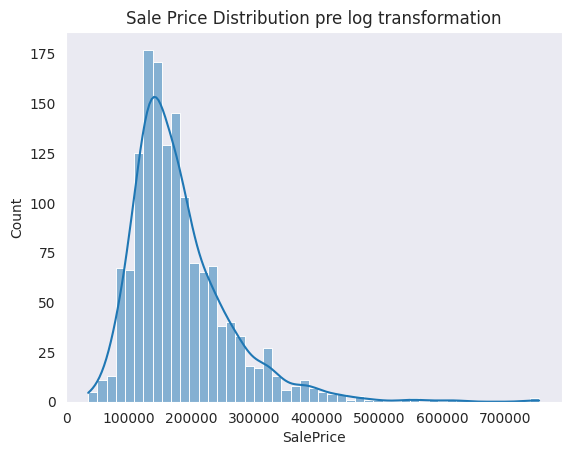

In [ ]:
# Check the distribution of the sale price - variable which we will predict
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Sale Price Distribution pre log transformation')
plt.show()

In [ ]:
# Log-transform skewed numerical features
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

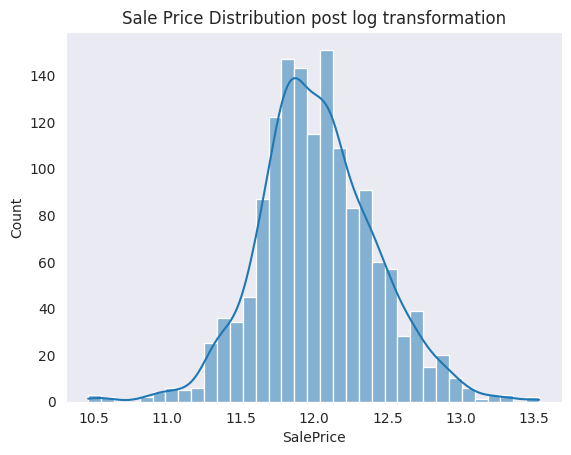

In [ ]:
# Check the distribution of the sale price post log transformation -> after transformation the distribution is less skewed and follow more normal distribution
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Sale Price Distribution post log transformation')
plt.show()

In [ ]:
#plt.figure(figsize=(12, 8))
#sns.heatmap(encoded_train_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
#plt.title("Correlation Heatmap")
#plt.show()

# Handle missing values

In [ ]:
# Check if there are any missing all values
train_df.columns[train_df.isnull().all()]

Index([], dtype='object')

In [ ]:
# Get top 20 columns with missing values
train_df.isnull().sum().sort_values(ascending=False).head(20)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81


In [ ]:
# Pools
train_df[train_df["PoolArea"]>0] # -> only 7 houses have a pool
train_df[train_df["PoolQC"].notnull()]

# Alley
train_df[train_df["Alley"].notnull()]

# MiscFeature
train_df[train_df["MiscFeature"].notnull()]

# Fence
train_df[train_df["Fence"].notnull()]["Fence"].head(50)

# MasVnrType
train_df[train_df["MasVnrType"].notnull()]["MasVnrType"].head(50)

# Fireplace
train_df[train_df["FireplaceQu"].notnull()][["FireplaceQu", "Fireplaces"]].head(50)
train_df[train_df["Fireplaces"]==0]

# LotFrontage
train_df[train_df["LotFrontage"].notnull()]["LotFrontage"].head(50)
train_df[train_df["LotFrontage"].isnull()]["LotFrontage"].head(50)
train_df[train_df["LotFrontage"]>0]

# Garage
train_df[train_df["GarageCond"].isnull()]
train_df[train_df["GarageCond"].isnull()][["GarageCond", "GarageType", "GarageFinish", "GarageQual"]].head(50)

# Basement
train_df[train_df["BsmtFinType2"].isnull()]
train_df[train_df["BsmtFinType2"].isnull()][["BsmtExposure", "BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2"]].head(50)
train_df[train_df["BsmtExposure"].notnull()].head(50)
train_df[train_df["BsmtQual"].isnull()][["BsmtQual", "BsmtCond", "BsmtFinType1"]].head(50)
train_df[train_df["BsmtExposure"].isnull()][["BsmtExposure", "BsmtQual", "BsmtCond", "BsmtFinType1"]].head(50)

# MasVnrArea
train_df[train_df["MasVnrArea"].isnull()].head(50)

# Electrical
train_df[train_df["Electrical"].notnull()].head(50)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,

Categorical variables:
* PoolQC	(1453) PoolQC: Pool quality -> NaN should be encoded to no_pool
* MiscFeature	(1406) MiscFeature: Miscellaneous feature not covered in other categories -> NaN should be encoded to no_misc_feature
* Alley	(1369) Alley: Type of alley access -> NaN should be encoded to no_alley
* Fence	(1179) Fence: Fence quality ->  NaN should be encoded to no_fence
* MasVnrType	(872) MasVnrType: Masonry veneer type -> NaN should be encoded to no_mas_vnr
* FireplaceQu	(690) FireplaceQu: Fireplace quality -> NaN should be encoded to no_fireplace
* GarageCond	(81) GarageCond: Garage condition -> NaN should be encoded to no_garage
* GarageType	(81) GarageType: Garage location -> NaN should be encoded to no_garage
* GarageFinish	(81) GarageFinish: Interior finish of the garage -> NaN should be encoded to no_garage
* GarageQual	(81) GarageQual: Garage quality -> NaN should be encoded to no_garage
* BsmtFinType2	(38) BsmtFinType2: Quality of second finished area (if present) -> NaN should be encoded to no_second_bsmt
* BsmtExposure	(38) BsmtExposure: Walkout or garden level basement walls -> NaN should be encoded to no_basement exposure
* BsmtQual	(37) BsmtQual: Height of the basement -> NaN should be encoded to no_bsmt
* BsmtCond	(37) BsmtCond: General condition of the basement -> NaN should be encoded to no_bsmt
* BsmtFinType1	(37) BsmtFinType1: Quality of basement finished area -> NaN should be encoded to no_bsmt
* Electrical (1): Electrical system -> NaN should be encoded to no_elec_systm


Numerical variables:
* LotFrontage	(259) LotFrontage: Linear feet of street connected to property -> encoded with median, because 0 might not be appropriate. I believe so, because only 81 properties don't have a garage, which indicates that there are properties with a garage, but with the LotFrontage missing value
* GarageYrBlt	(81) GarageYrBlt: Year garage was built -> NaN should be encoded to 0 (this is equivalent to no garage)
* MasVnrArea	(8) MasVnrArea: Masonry veneer area in square feet -> check distribution and decide to endcode as median, mode or 0

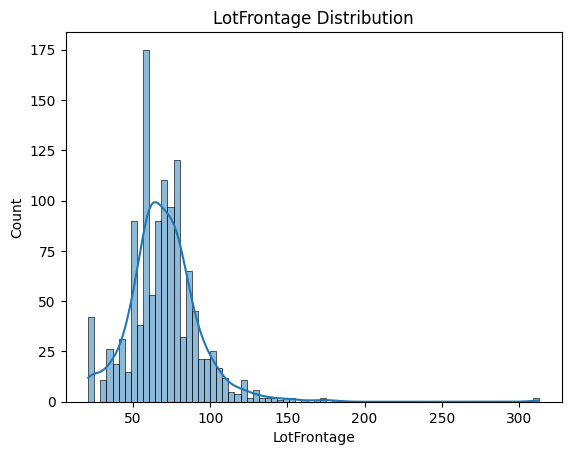

In [ ]:
# Check the distribution of LotFrontage
sns.histplot(train_df['LotFrontage'], kde=True)
plt.title('LotFrontage Distribution')
plt.show()

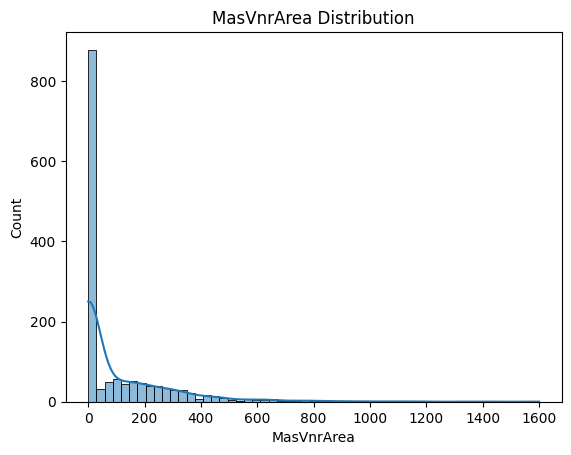

In [ ]:
# Check the distribution of MasVnrArea -> median, mode and mean are all equal to zero, hence the empty values will be also converted to 0
sns.histplot(train_df['MasVnrArea'], kde=True)
plt.title('MasVnrArea Distribution')
plt.show()

In [ ]:
# Categorical variables: Replace NaN with specified placeholder values
categorical_fill_values = {
    'PoolQC': 'no_pool',
    'MiscFeature': 'no_misc_feature',
    'Alley': 'no_alley',
    'Fence': 'no_fence',
    'MasVnrType': 'no_mas_vnr',
    'FireplaceQu': 'no_fireplace',
    'GarageCond': 'no_garage',
    'GarageType': 'no_garage',
    'GarageFinish': 'no_garage',
    'GarageQual': 'no_garage',
    'BsmtFinType2': 'no_second_bsmt',
    'BsmtExposure': 'no_basement_exposure',
    'BsmtQual': 'no_bsmt',
    'BsmtCond': 'no_bsmt',
    'BsmtFinType1': 'no_bsmt',
    'Electrical': 'no_elec_systm'
}

train_df.fillna(value=categorical_fill_values, inplace=True)

In [ ]:
# Numerical variables:

# LotFrontage: Replace NaN with the median value
train_df['LotFrontage'].fillna(train_df['LotFrontage'].median(), inplace=True)

# GarageYrBlt: Replace NaN with 0
train_df['GarageYrBlt'].fillna(0, inplace=True)

# Replace NaN with median (same as 0)
train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].median(), inplace=True)

<ipython-input-15-ef41d81e833c>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['LotFrontage'].fillna(train_df['LotFrontage'].median(), inplace=True)
<ipython-input-15-ef41d81e833c>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

In [ ]:
# Get top 20 columns with missing values - post-change check (successful since all are 0)
train_df.isnull().sum().sort_values(ascending=False).head(20)

,0
Id,0
CentralAir,0
GarageYrBlt,0
GarageType,0
FireplaceQu,0
Fireplaces,0
Functional,0
TotRmsAbvGrd,0
KitchenQual,0
KitchenAbvGr,0


# Feature Engineering

In this section I will implement the following adjustments to allow handling of categorical features and improve the performance of the later applied models:

**1. Encoding categorical values**
  
  a. Reason: Categorical text values in the dataset cannot be handled by some of the models, so they need to converted to numerical values

  b. Approach: Hybrid of Label and One-Hot encoding. Since some of the values are hierarchical (e.g. OverallQual, PoolQC), so they will be encoded using Label Encoding. The rest, which does not exibit hierarchical order, will be encoded using One-Hot encoding

  c: Motivation: Label encoding allows to preserve hierarchical values, which is beneficial for some models (e.g. Linear Regression). Moreover, it allows to reduce dimensionality of the encoded dataset, which is helpful as we are already dealing with a limited number of observations and many features

**2. Log Transformation of SalePrice**

  a. Reason: The target variable SalePrice exhibits right skewness, which can negatively impact model performance by introducing bias.

  b. Approach: Apply a log transformation to the SalePrice column using np.log1p().

  c. Motivation: Transforming SalePrice to a more normally distributed variable can improve the performance of models that assume normally distributed errors (e.g., Linear Regression).

**3. Scaling numerical features**

  a. Reason: Numerical features in the dataset vary in scale, which can lead to biased predictions in models sensitive to feature magnitudes (e.g., Logistic Regression, SVMs, Gradient Boosting).

  b. Approach: Use StandardScaler to standardize numerical features by subtracting the mean and dividing by the standard deviation, ensuring all features have a mean of 0 and a standard deviation of 1.

  c. Motivation: Scaling ensures fair treatment of all features in models that are distance-based or involve optimization techniques sensitive to magnitude differences.

**4. Introducing interaction features (on hold)**

  a. Reason:

  b. Approach:

  c. Motivation:

**5. Dropping irrelevant features (on hold)**

  a. Reason:

  b. Approach:

  c. Motivation:

Key for quality abbreviations:
* Ex: Excellent
* Gd: Good
* TA: Typical/Average
* Fa: Fair
* Po: Poor

In [ ]:
columns_to_check = [
    # Hierarchical (Ordinal) Columns
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'LotShape',
    'LandSlope', 'LotShape', 'PavedDrive', 'Utilities', 'GarageFinish',
    'Fence', 'Alley',

    # Non-Hierarchical (Nominal) Columns
    'LotConfig', 'MSZoning', 'Street', 'LandContour', 'Neighborhood', 'Condition1',
    'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
    'CentralAir', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType',
    'SaleCondition'
]

# Iterate through the columns and print unique values
for col in columns_to_check:
    print(f"{col} unique values: {train_df[col].unique()}")

ExterQual unique values: ['Gd' 'TA' 'Ex' 'Fa']
ExterCond unique values: ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual unique values: ['Gd' 'TA' 'Ex' 'no_bsmt' 'Fa']
BsmtCond unique values: ['TA' 'Gd' 'no_bsmt' 'Fa' 'Po']
HeatingQC unique values: ['Ex' 'Gd' 'TA' 'Fa' 'Po']
KitchenQual unique values: ['Gd' 'TA' 'Ex' 'Fa']
FireplaceQu unique values: ['no_fireplace' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageQual unique values: ['TA' 'Fa' 'Gd' 'no_garage' 'Ex' 'Po']
GarageCond unique values: ['TA' 'Fa' 'no_garage' 'Gd' 'Po' 'Ex']
PoolQC unique values: ['no_pool' 'Ex' 'Fa' 'Gd']
BsmtExposure unique values: ['No' 'Gd' 'Mn' 'Av' 'no_basement_exposure']
BsmtFinType1 unique values: ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'no_bsmt' 'LwQ']
BsmtFinType2 unique values: ['Unf' 'BLQ' 'no_second_bsmt' 'ALQ' 'Rec' 'LwQ' 'GLQ']
Functional unique values: ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
LotShape unique values: ['Reg' 'IR1' 'IR2' 'IR3']
LandSlope unique values: ['Gtl' 'Mod' 'Sev']
LotShape unique values: ['Reg' 'IR1' 'I

In [ ]:
# Define mappings for ordinal columns
ordinal_mappings = {
    # Quality ratings (Poor to Excellent following 1-5 and 0 if a missing value was encoded)
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'no_bsmt': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'no_bsmt': 0},
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'no_fireplace': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'no_garage': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'no_garage': 0},
    'PoolQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'no_pool': 0},

    # Feature sizes or levels
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'no_basement_exposure': 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'no_bsmt': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'no_second_bsmt': 0},

    # Functional (for explanation check Values in Functional in the Appendix)
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},

    # Lot shape (for explanation check Values in Functional in the Appendix)
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},

    # Land Slope (for explanation check Values in Functional in the Appendix)
    'LandSlope': {'Gtl': 3, 'Mod': 2, 'Sev': 1},

    # Paved Driveway (for explanation check Values in Functional in the Appendix)
    'PavedDrive': {'Y': 2, 'P': 1, 'N': 0},

    # Utilities (for explanation check Values in Functional in the Appendix)
    'Utilities': {'AllPub': 2, 'NoSeWa': 1, 'ELO': 0},

    # Garage Finish (for explanation check Values in Functional in the Appendix)
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'no_garage': 0},

    # Fence (for explanation check Values in Functional in the Appendix)
    'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'no_fence': 0},

    # Alley Access (for explanation check Values in Functional in the Appendix)
    'Alley': {'Pave': 2, 'Grvl': 1, 'no_alley': 0},

}


In [ ]:
# Apply mappings to the hierarchical columns
for col, mapping in ordinal_mappings.items():
    train_df[col] = train_df[col].map(mapping)

In [ ]:
# Non-hierarchical (nominal) columns
non_hierarchical_columns = [
    'LotConfig', 'MSZoning', 'Street', 'LandContour', 'Neighborhood', 'Condition1',
    'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
    'CentralAir', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType',
    'SaleCondition'
]


In [ ]:
# Perform one-hot encoding for non-hierarchical columns
train_df = pd.get_dummies(train_df, columns=non_hierarchical_columns, drop_first=True)

In [ ]:
# Check if all object columns got encoded -> no more object columns indicating success
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 204 entries, Id to SaleCondition_Partial
dtypes: bool(145), float64(3), int64(56)
memory usage: 879.8 KB


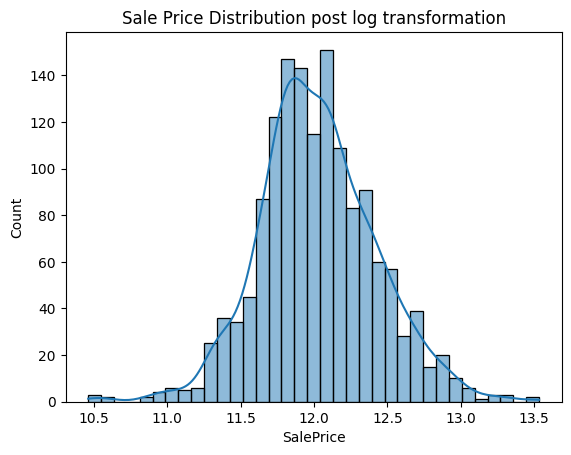

### 3. Scaling numerical features

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
numerical_features = train_df.select_dtypes(include=['float64', 'int64']).columns
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])

# Data split & Model selection

1. Given that that test data is stored separately I will only split the train_df into train and val (i.e. validation).

2. Model selection
  
  a. Linear Regression (Baseline)

  * Reasoning: It's a relatively simple and interpretible model.
  * Weaknesses: Due to the high number of parameters performance will be likely affected by irrelevant and collinear features. Morever, it will not allow to model non-linear relations

  b. Regularized Regression (Ridge, Lasso, Elastic Net)

  * Reasoning: Corrects for the problem of too many parameters, which should reduce overfitting

  c. Random Forest Regressor

  * Reasoning: Tree-based models offer a way to model non-linear relations, which could offer better results

  d. Gradient Boosing Machines

  * Reasoning:

  e. SVR

  * Reasoning: SVR can offer good performance on small datasets (such as this one) and allows to model non-linear relations

3. Hyperparameter tuning

* Linear Regression:

* Regularized Regression:

* Random Forest Regressor:

* Gradient Boosing Machines:

* SVR:





In [ ]:
from sklearn.model_selection import train_test_split

# Assume train_df is the training set and test_df is the separate test set
X = train_df.drop(columns=['SalePrice'])  # Replace 'SalePrice' with your target column
y = train_df['SalePrice']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

Training set size: (1168, 203)
Validation set size: (292, 203)


In [ ]:
# Import necessary modules
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Initialize the baseline model
baseline_model = LinearRegression()

# Perform cross-validation on training set only
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE
baseline_rmse = (-cv_scores.mean()) ** 0.5
print("Baseline Model - Linear Regression RMSE on Training Set:", baseline_rmse)

Baseline Model - Linear Regression RMSE on Training Set: 151074963490.08533


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5),  # Hybrid of Ridge and Lasso
    'Support Vector Regression (SVR)': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'k-Nearest Neighbors (k-NN)': KNeighborsRegressor(n_neighbors=5),  # Default k=5
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Evaluate models with cross-validation
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = (-cv_scores.mean()) ** 0.5
    print(f"{name} RMSE: {rmse}")


Linear Regression RMSE: 151074963490.08533
Ridge Regression RMSE: 0.385957016311568
Lasso Regression RMSE: 0.44274127533622076
Elastic Net RMSE: 0.4070873385170337
Support Vector Regression (SVR) RMSE: 0.3798920337587525
k-Nearest Neighbors (k-NN) RMSE: 0.44668453521524093
Random Forest RMSE: 0.3644615638110425
Gradient Boosting RMSE: 0.33457598907223707


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Parameter grids for each model
param_grids = {
    'Ridge Regression': {
        'alpha': [0.1, 1, 10, 100]
    },
    'Lasso Regression': {
        'alpha': [0.01, 0.1, 1, 10]
    },
    'Elastic Net': {
        'alpha': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.2, 0.5, 0.8]
    },
    'Support Vector Regression (SVR)': {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 1]
    },
    'k-Nearest Neighbors (k-NN)': {
        'n_neighbors': [3, 5, 10, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10]
    }
}

# Loop through models and tune
best_models = {}
for name, params in param_grids.items():
    print(f"Tuning {name}...")
    model = {
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Elastic Net': ElasticNet(),
        'Support Vector Regression (SVR)': SVR(),
        'k-Nearest Neighbors (k-NN)': KNeighborsRegressor(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }[name]

    # Grid search
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train if name in ['Support Vector Regression (SVR)', 'k-Nearest Neighbors (k-NN)'] else X_train, y_train)

    # Save best model
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best RMSE for {name}: {(-grid_search.best_score_) ** 0.5}")

Tuning Ridge Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Ridge Regression: {'alpha': 10}
Best RMSE for Ridge Regression: 0.374180403261734
Tuning Lasso Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Lasso Regression: {'alpha': 0.01}
Best RMSE for Lasso Regression: 0.38386123348217704
Tuning Elastic Net...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Elastic Net: {'alpha': 0.01, 'l1_ratio': 0.2}
Best RMSE for Elastic Net: 0.3727227426849144
Tuning Support Vector Regression (SVR)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for Support Vector Regression (SVR): {'C': 1, 'epsilon': 0.01}
Best RMSE for Support Vector Regression (SVR): 0.3735037193344034
Tuning k-Nearest Neighbors (k-NN)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for k-Nearest Neighbors (k-NN): {'metric': 'manhattan', 'n_nei

# Adjustments

Gradient Boosting followed by Random Forest perform the best at the moment and, however the scores achieved are not great compared to other competitors on Kaggle.

I will conduct the following steps aimed at model performance improvement:

1. Explore more Gradient Boosting Models (e.g. CatBoost, LightGBM, and XGBoost)
2. Focus further on hyperparameter tuning
3. Review and adjust feature engineering (add or skip certain transformations and pick top performers)
4. Try ensamble models

In [ ]:
#!pip install catboost

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Define the models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(n_estimators=100, verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

# Evaluate models with cross-validation
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = (-cv_scores.mean()) ** 0.5
    print(f"{name} RMSE: {rmse}")

Random Forest RMSE: 0.3644615638110425
Gradient Boosting RMSE: 0.33457598907223707
CatBoost RMSE: 0.3243175343424239
LightGBM RMSE: 0.3349547909679075


In [ ]:
# Define parameter grid
catboost_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize CatBoost model
catboost = CatBoostRegressor(loss_function='RMSE', random_state=42, verbose=0)

# Perform Grid Search
catboost_grid_search = GridSearchCV(catboost, catboost_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
catboost_grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters for CatBoost:", catboost_grid_search.best_params_)
print("Best CatBoost RMSE:", (-catboost_grid_search.best_score_) ** 0.5)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for CatBoost: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best CatBoost RMSE: 0.30966488099538475


In [ ]:
# Define parameter grid
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [20, 31, 40],
    'max_depth': [3, 5, 7]
}

# Initialize LightGBM model
lgbm = LGBMRegressor(random_state=42)

# Perform Grid Search
lgbm_grid_search = GridSearchCV(lgbm, lgbm_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
lgbm_grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters for LightGBM:", lgbm_grid_search.best_params_)
print("Best LightGBM RMSE:", (-lgbm_grid_search.best_score_) ** 0.5)

# Resources for trying to boost the score

How I Cracked the Top 100 in the Kaggle House Prices Competition
* Article: https://blog.finxter.com/how-i-cracked-the-top-100-in-the-kaggle-house-prices-competition/?utm_source=chatgpt.com
* Code 1: https://www.kaggle.com/code/onehundreddays/house-prices-top-100-score
* Code 2: https://www.kaggle.com/code/thegamer7675/midterm-210045452

Takeaways:
1. Adjust feature engineering approaches
* Imputing data in different ways
* Interaction features
* Exploring relationships
2. Ensamble models


In [ ]:
# Drop columns manually or using variance threshold
# train_df.drop(['Id', 'MiscVal'], axis=1, inplace=True)  # Example irrelevant features


In [ ]:
# Generate report
#profile = ProfileReport(df, title="House Prices Dataset EDA", explorative=True)
#profile.to_notebook_iframe()  # Or profile.to_file('eda_report.html')


# Appendix

*Values in Functional*

Here are the possible values and their meanings:

* Typ: Typical Functionality

  No major issues with functionality. The house layout and features are considered standard and meet typical needs.


* Min1: Minor Deductions 1

  Minor functionality issues, such as a single feature that slightly detracts from usability (e.g., one outdated bathroom).

* Min2: Minor Deductions 2

  Two or more minor functionality issues.

* Mod: Moderate Deductions

  Moderate functionality problems that slightly impact usability, such as a small kitchen or limited storage.

* Maj1: Major Deductions 1

  One major functionality problem, such as a poorly located staircase or an awkward room layout.

* Maj2: Major Deductions 2

  Two or more major functionality problems that significantly detract from usability.

* Sev: Severely Damaged

  Severe functionality problems, such as multiple unusable rooms or severely outdated features.

* Sal: Salvage Only

  House is barely functional and may require substantial renovations or rebuilding to be livable.

*Values in LotShape*

Here are the possible values and their meanings:

* Reg: Regular

  The lot is rectangular or close to rectangular in shape. This is the most desirable shape as it maximizes usability for construction and landscaping.

* IR1: Slightly Irregular

  The lot has a slight irregularity but is still mostly usable for construction and other purposes.

* IR2: Moderately Irregular

  The lot has moderate irregularity, which may limit some construction options or reduce overall usability.

* IR3: Highly Irregular

  The lot has significant irregularity, making it the least desirable shape. It may impose significant limitations on construction, landscaping, or other uses.


LandSlope: Slope of the property.

Values: Gtl (Gentle), Mod (Moderate), Sev (Severe).
Order: Gtl > Mod > Sev.
Utilities: Availability of utilities.

Values: AllPub (All public utilities), NoSewr (No sewer), NoSeWa (No sewer or water), ELO (Electric only).
Order: AllPub > NoSewr > NoSeWa > ELO.
PavedDrive: Paved driveway status.

Values: Y (Paved), P (Partial), N (Dirt/Gravel).
Order: Y > P > N.
Fence: Fence quality.

Values: GdPrv (Good Privacy), MnPrv (Minimum Privacy), GdWo (Good Wood), MnWw (Minimum Wood/Wire), no_fence.
Order: GdPrv > MnPrv > GdWo > MnWw > no_fence.
GarageFinish: Interior finish of the garage.

Values: Fin (Finished), RFn (Rough Finished), Unf (Unfinished), no_garage.
Order: Fin > RFn > Unf > no_garage.
Alley: Type of alley access.

Values: Pave (Paved), Grvl (Gravel), no_alley.
Order: Pave > Grvl > no_alley.